# Práctica: Detectar Panes
### Daniel Marín López
---
En esta tarea partiremos de las dos fotos que se adjuntan para, con procesamiento en OpenCV, cuantificar cuál ha sido la variación de volumen del pan. Este volumen no ha de expresarse en ninguna unidad en concreto, sólo un referencia a la primera imagen, es decir, de forma relativa: el pan de la segunda foto es un 110%, un 150% o un 200% sobre el de la primera foto.

Primero instalamos las librerías necesarias para el proyecto.

In [1]:
!pip install rembg
!pip install onnxruntime
!pip install python-telegram-bot

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 63.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 673.5/673.5 kB 8.8 MB/s eta 0:00:00


In [2]:
import os
import sys
import time
from rembg import remove
from PIL import Image
import io
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import re
from datetime import datetime

# from zipfile import ZipFile
from urllib.request import urlretrieve

from IPython.display import YouTubeVideo, display, Image

%matplotlib inline

---
### Código para un fichero de entrada y salida

La función `create_output_data` recibirá los ficheros de entrada, procesado y sálida. Si estos ficheros no están los crea, si está vacío el fichero de entrada se lo indicará al usuario para que meta las fotos.

Si todo va bien, la función procesará las fotos al fichero de procesado con las imágenes sin el fondo.

In [3]:
AVISOS = [50, 75, 80, 90, 100]
ultimo_aviso_enviado = None

In [20]:
def format_time(seconds):
    """Convierte segundos a formato HH:MM:SS"""
    if seconds < 60:
        return f"{int(seconds)}s"
    elif seconds < 3600:
        minutes = int(seconds // 60)
        seconds = int(seconds % 60)
        return f"{minutes}m {seconds}s"
    else:
        hours = int(seconds // 3600)
        minutes = int((seconds % 3600) // 60)
        seconds = int(seconds % 60)
        return f"{hours}h {minutes}m {seconds}s"

In [21]:
def create_ouput_data(input_folder, output_folder, processed_folder):
  # Comprobamos que los ficheros existen
  if not os.path.exists(input_folder):
    os.makedirs(input_folder)
    print(f"La carpeta de entrada '{input_folder}' no existe. Se ha creado.")

  if not os.path.exists(output_folder):
    os.makedirs(output_folder)
    print(f"La carpeta de salida '{output_folder}' no existe. Se ha creado.")

  if not os.path.exists(processed_folder):
    os.makedirs(processed_folder)
    print(f"La carpeta de procesado '{processed_folder}' no existe. Se ha creado.")

  # Comprobamos que en input_folder hay archivos, si no sale
  if not os.listdir(input_folder):
    print(f"La carpeta de entrada '{input_folder}' está vacía.")
    return
  else:
    file_list = [f for f in os.listdir(input_folder) if f.endswith((".jpg", ".png"))]

  total_files = len(file_list)
  start_time = time.time()

  # Recorremos la carpeta input_folder
  for i, filename in enumerate(file_list, start=1):
    if filename.endswith(".jpg") or filename.endswith(".png"):
      input_path = os.path.join(input_folder, filename)
      img = cv2.imread(input_path)

      # print(f"Procesando imagen: {filename}")
      # Tratamos la imagen para quedarnos solo con el objeto (pan)
      img_remove = remove(img)
      output_gray = cv2.cvtColor(img_remove, cv2.COLOR_BGR2GRAY)
      _, mask = cv2.threshold(output_gray, 10, 255, cv2.THRESH_BINARY)
      result = cv2.bitwise_and(img_remove, img_remove, mask=mask)

      # Guardamos la imagen procesada
      output_path = os.path.join(processed_folder, f"processed_{filename}")
      cv2.imwrite(output_path, result)

      # print(f"Imagen procesada guardada en: {output_path}")

      progress = (i / total_files) * 100

      # Estimación del tiempo restante
      elapsed_time = time.time() - start_time
      avg_time_per_image = elapsed_time / i  # Tiempo promedio por imagen
      remaining_time = avg_time_per_image * (total_files - i)  # Tiempo estimado restante

      # Formateamos el tiempo restante
      formatted_time = format_time(remaining_time)

      # Mostramos el progreso en la misma línea
      sys.stdout.write(f"\rProgreso: {progress:.2f}% | Tiempo restante: {formatted_time}   ")
      sys.stdout.flush()

  print("\nProcesamiento completado.")

In [22]:
create_ouput_data('input_data', 'output_data', 'processed_data')

Progreso: 100.00% | Tiempo restante: 0s   
Procesamiento completado.


La función `extraer_fecha` extraerá la fecha de la foto que hay en su nombre.

In [6]:
def extraer_fecha(archivo):
    """Extrae la fecha y hora del nombre del archivo en formato datetime."""
    patron = r'processed_captura_(\d{4}-\d{2}-\d{2}) (\d{2}_\d{2}_\d{2})'
    coincidencia = re.search(patron, archivo)

    if coincidencia:
        fecha_str = coincidencia.group(1)  # YYYY-MM-DD
        hora_str = coincidencia.group(2).replace('_', ':')  # HH:MM:SS
        fecha_hora_str = f"{fecha_str} {hora_str}"
        return datetime.strptime(fecha_hora_str, "%Y-%m-%d %H:%M:%S")

    return datetime.min  # Si no se puede extraer la fecha, devolver un mínimo para evitar errores

La función `calcular_volumen_entre_imagenes` es el núcleo de la aplicación ya que es la encargada de calcular los volúmenes en las fotos (en píxeles cúbicos) y sacar el porcentaje de crecimiento entre la primera y última foto.

Esta función tiene dos funciones dentro:

* La función `aislar_transparencia` que devuelve la imagen procesada sin el fondo negro.
* La función `calcular_volumen_a` se encargará de realizar las siguientes tareas:

  - Calcular el volumen de la imagen.
  - Dibujar en la imagen normal (de entrada) la elipse inicial y la de crecimiento.
  - Indicar en la foto los datos como fecha, hora y porcentaje actual.

Este proceso se repite a través de todas las imágenes del procesado hasta la última y sacar por pantalla el porcentaje total entre la primera y última foto. Luego se devuelven los volúmenes y fechas para usarlas en el gráfico.

In [8]:
def calcular_volumen_entre_imagenes(input_folder, process_folder, output_folder):
    """
    Calcula la diferencia de volumen entre la primera y la última imagen de una carpeta y guarda imágenes procesadas.

    Args:
        input_folder: Ruta a la carpeta que contiene las imágenes sin procesar.
        process_folder: Ruta a la carpeta que contiene las imágenes procesadas sin fondo.
        output_folder: Ruta a la carpeta donde se guardarán las imágenes con la elipse y datos.
    """

    def aislar_transparencias(image):
        if image.shape[2] == 4:
            alpha_channel = image[:, :, 3]
            binary = (alpha_channel > 0).astype(np.uint8) * 255
        else:
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            _, binary = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
        return binary

    def obtener_aviso_mas_alto(volumen_relativo):
      aviso_mas_alto = None
      for aviso in AVISOS:
          if volumen_relativo >= aviso:
              aviso_mas_alto = aviso  # Guarda el mayor aviso válido

      return aviso_mas_alto

    def imprimir_aviso_imagen(image, aviso):
      text = f"Aviso: Volumen > {aviso}%"
      x, y = 260, 460
      (text_width, text_height), baseline = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 1, 2)
      cv2.rectangle(image, (x - 5, y - text_height - 5), (x + text_width + 5, y + baseline + 5), (0, 0, 255), 2)
      cv2.putText(image, text, (x, y), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
      return image

    def mandar_aviso(aviso):
      MENSAJE = f"¡OJO! ¡El pan ha superado un volumen de {aviso}%!"
      try:
          response = requests.post(URL, data={"chat_id": CHAT_ID, "text": MENSAJE})
      except Exception as e:
          print(f"Error al enviar el mensaje: {e}")


    def calcular_volumen_a(binary, image, output_path, filename, fecha_str, hora_str, primer_volumen, primera_elipse):
        global ultimo_aviso_enviado
        contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if not contours:
            print(f"No se encontraron contornos en {filename}")
            return None, None, None, None

        contour = max(contours, key=cv2.contourArea)
        (x, y), (major_axis, minor_axis), angle = cv2.fitEllipse(contour)
        height = minor_axis * 0.6
        a = major_axis / 2
        b = minor_axis / 2
        c = height / 2
        volume = (4 / 3) * np.pi * a * b * c / 2

        output_image = image.copy()
        if primera_elipse:
            cv2.ellipse(output_image, ((int(x), int(y)), (int(primera_elipse[0]), int(primera_elipse[1])), primera_elipse[2]), (0, 0, 255), 2)  # Rojo
        cv2.ellipse(output_image, ((int(x), int(y)), (int(major_axis), int(minor_axis)), angle), (0, 255, 0), 2)  # Verde

        text_dia = f"{fecha_str}"
        text_hora = f"{hora_str}"
        if primer_volumen is not None:
            volumen_relativo = ((volume / primer_volumen) * 100) - 100
        else:
            volumen_relativo = 0
        text_volumen = f"Volumen: {volumen_relativo:.2f}%"
        cv2.putText(output_image, text_dia, (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        cv2.putText(output_image, text_hora, (20, 80), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        cv2.putText(output_image, text_volumen, (20, 120), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)


        aviso_mostrar = obtener_aviso_mas_alto(volumen_relativo)
        if aviso_mostrar is not None:
            output_image = imprimir_aviso_imagen(output_image, aviso_mostrar)

        if aviso_mostrar is not None and aviso_mostrar != ultimo_aviso_enviado:
          # mandar_aviso(aviso_mostrar)
          ultimo_aviso_enviado = aviso_mostrar  # Actualizamos el último aviso enviado

        output_filepath = os.path.join(output_path, filename)
        cv2.imwrite(output_filepath, output_image)
        # print(f"Imagen guardada en {output_filepath}")

        return volume, a, b, (major_axis, minor_axis, angle)

    volumenes = []
    fechas = []
    eje_a = []
    eje_b = []
    primer_volumen = None
    primera_elipse = None

    image_files = sorted([f for f in os.listdir(process_folder) if f.endswith(('.png', '.jpg'))], key=extraer_fecha)
    if not image_files:
        print("No se encontraron imágenes en la carpeta especificada.")
        return

    for i, filename in enumerate(image_files):
        input_filename = filename.replace("processed_", "", 1)
        input_filepath = os.path.join(input_folder, input_filename)
        process_filepath = os.path.join(process_folder, filename)
        image = cv2.imread(input_filepath, cv2.IMREAD_UNCHANGED)
        binary = cv2.imread(process_filepath, cv2.IMREAD_UNCHANGED)
        binary = aislar_transparencias(binary)

        patron = r'processed_captura_(\d{4}-\d{2}-\d{2}) (\d{2}_\d{2}_\d{2})'
        coincidencia = re.search(patron, filename)

        if coincidencia:
            fecha_str = coincidencia.group(1)
            hora_str = coincidencia.group(2).replace('_', ':')

        # Calcular volumen y elipse
        volume, a, b, elipse = calcular_volumen_a(binary, image, output_folder,
                                                  filename, fecha_str, hora_str,
                                                  primer_volumen,
                                                  primera_elipse)

        if volume is not None:
            volumenes.append(volume)
            fechas.append(extraer_fecha(filename).strftime("%Y-%m-%d %H:%M:%S"))
            eje_a.append(a)
            eje_b.append(b)
            if primera_elipse is None:
                primera_elipse = elipse
            if primer_volumen is None:
                primer_volumen = volume  # Asignar primer volumen al principio

    if volumenes:
        diferencia_volumen = (volumenes[-1] / volumenes[0] * 100) - 100
        print(f"Cambio de volumen entre la primera y la última imagen: {diferencia_volumen:.2f}%")
    else:
        print("No se pudieron procesar las imágenes correctamente.")

    return volumenes, fechas


In [9]:
volumenes, fechas = calcular_volumen_entre_imagenes('input_data', 'processed_data', 'output_data')

Cambio de volumen entre la primera y la última imagen: 82.77%


Este código crea un gráfico en donde se muestran el crecimiento paulatino del pan entre las fotos. Las fechas nos ayudarán a representar la gráfica más realista de forma que los saltos en donde no haya fotos quede reflejado. En este caso, el tiempo pasa cada 10 minutos.

In [10]:
prc_colors = {
    50: 'yellow',
    75: 'orange',
    80: 'red',
    90: 'brown',
    100: 'purple'
}

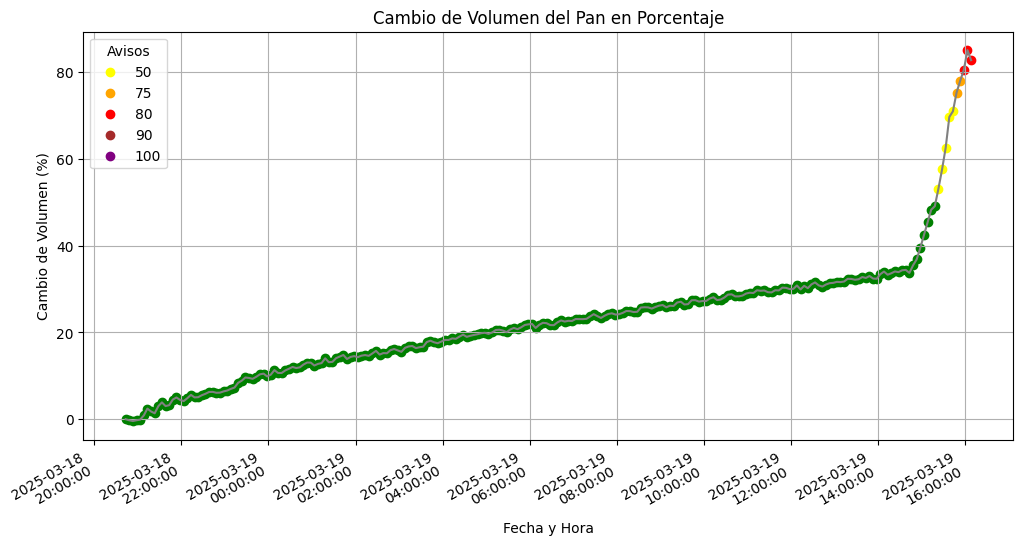

In [12]:
fechas2 = [datetime.strptime(f, "%Y-%m-%d %H:%M:%S") for f in fechas]  # Convertir a datetime

if volumenes:
    primer_volumen = volumenes[0]  # Volumen de referencia (primer frame)

    # Calcular el cambio de volumen en porcentaje
    volumenes_porcentaje = [(v / primer_volumen * 100) - 100 for v in volumenes]

    # Graficar
    plt.figure(figsize=(12, 6))

    # Iterar sobre los puntos y graficar con color
    for i, (fecha, porcentaje) in enumerate(zip(fechas2, volumenes_porcentaje)):
        color = None  # Color por defecto
        for aviso, color_aviso in prc_colors.items():
            if porcentaje >= aviso:
                color = color_aviso  # Actualiza el color si se cumple el aviso
        # Graficar el punto con el color asignado
        plt.scatter(fecha, porcentaje, marker='o', color=color or 'green')  # Azul si no hay aviso
        # plt.text(fecha, porcentaje + 2, f"{porcentaje:.2f}%", fontsize=8, ha='center', color='black')

    plt.plot(fechas2, volumenes_porcentaje, linestyle='-', color='gray')

    # Personalizar el gráfico
    plt.xlabel("Fecha y Hora")
    plt.ylabel("Cambio de Volumen (%)")
    plt.title("Cambio de Volumen del Pan en Porcentaje")
    plt.grid(True)

    # Ajustar eje X para reflejar tiempos reales
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d\n%H:%M:%S"))
    plt.gcf().autofmt_xdate()  # Rotar etiquetas automáticamente

    labels = list(prc_colors.keys())
    handles = [plt.scatter([], [], marker='o', color=color) for color in prc_colors.values()]
    plt.legend(handles, labels, title="Avisos")

    # Mostrar el gráfico
    plt.show()
else:
    print("No hay volúmenes para graficar.")

Por último, tenemos la función `create_video_from_images` que se encargará de recoger las imágenes en el fichero de sálida y devolverlo en un archivo mp4. Se ha indicado una pausa de 2 segundos entre fotogramas.

In [27]:
def create_video_from_images(image_folder, video_name="output_video.mp4", fps=5, seconds_delay = None):
    images = [img for img in os.listdir(image_folder) if img.endswith((".png", ".jpg", ".jpeg"))]
    images.sort()  # Sort images for correct order in video

    if not images:
        print("No hay imágenes en el fichero")
        return

    frame = cv2.imread(os.path.join(image_folder, images[0]))
    height, width, layers = frame.shape

    video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))

    for image in images:
        frame = cv2.imread(os.path.join(image_folder, image))
        video.write(frame)

        if seconds_delay is not None:
            # Agregar pausa de 2 segundos (duplicar el frame 2 * fps veces)
            for _ in range(seconds_delay * fps):
                video.write(frame)

    # cv2.destroyAllWindows()
    video.release()
    print(f"Video '{video_name}' creado con éxito.")

In [28]:
create_video_from_images("output_data", fps=4)

Video 'output_video.mp4' creado con éxito.


---
### Bot de Telegram

In [ ]:
import requests

In [ ]:
# TOKEN del bot de Telegram
TOKEN = "7963824793:AAHR0L7xpLeq5-KLHa4dj02L-5aboC_D7OY"

# ID del chat (puede ser tuyo o de un grupo)
CHAT_ID = "-4731656695"

URL = f"https://api.telegram.org/bot{TOKEN}/sendMessage"

In [ ]:
from telegram.ext import Updater, CommandHandler